In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/vgg16"))
print(os.listdir("../input/resnet50"))

# Any results you write to the current directory are saved as output.

['vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'imagenet_class_index.json']
['resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'imagenet_class_index.json']


**1. Preprocess images**

In [2]:
import random
import cv2
import math
import matplotlib.pyplot as plt

# Preprocessing functions
"""
remove the black borders of an img
"""
def cut_black(img, tol=5):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = img_gray > tol
    idx = np.ix_(mask.any(1),mask.any(0))
    return img[idx[0], idx[1], :]


"""
Only take the center
"""
def crop_center(img):
    H, W = img.shape[0], img.shape[1]
    if H == W:
        return img
    elif H > W:
        return img[H//2-W//2:H//2+W//2, :, :]
    else:
        return img[:, W//2-H//2:W//2+H//2, :]
        
        
"""
Adjust brightness, scale to mean 100
"""
def adjust_light(img):
    brightness = np.mean(img)
    return np.clip(100.0/brightness*img, 0, 255).astype(int)


"""
Crop image based off black pixels on diagon
"""
def crop_diagonal(img, tol=5):
    img_diag = np.diagonal(img)
    img_diag_gray = np.mean(img_diag, axis=0).astype('int32')
    idx0 = np.argmax(img_diag_gray>tol)
    idx1 = len(img_diag_gray) - np.argmax(img_diag_gray[::-1]>tol)
    return img[idx0:idx1, idx0:idx1, :]

In [3]:
train_dir = "../input/aptos2019-blindness-detection/train_images"
test_dir = "../input/aptos2019-blindness-detection/test_images"
train_dir_processed = "../train_processed"
test_dir_processed = "../test_processed"
val_dir_processed = "../val_processed"
train_label_file = "../input/aptos2019-blindness-detection/train.csv"
test_name_file = "../input/aptos2019-blindness-detection/test.csv"
test_pred_file = "../input/aptos2019-blindness-detection/test_pred.csv"

if not os.path.exists(train_dir_processed):
    os.mkdir(train_dir_processed)
if not os.path.exists(test_dir_processed):
    os.mkdir(test_dir_processed)
if not os.path.exists(val_dir_processed):
    os.mkdir(val_dir_processed)

train_labels = pd.read_csv(train_label_file)
classes = train_labels['diagnosis'].unique()

global N, C, L
N = train_labels.shape[0]
C = classes.size
L = 224

print("process train")
os.system('echo ' + 'process train')
train_imgs = os.listdir(train_dir)
for train_img in train_imgs:
    img = cv2.imread(os.path.join(train_dir, train_img))
    img = cut_black(img)
    img = crop_center(img)
    img = crop_diagonal(img)
    img = adjust_light(img)
    cv2.imwrite(os.path.join(train_dir_processed, train_img), img)

print("process test")
os.system('echo ' + 'process test')
test_imgs = os.listdir(test_dir)
for test_img in test_imgs:
    img = cv2.imread(os.path.join(test_dir, test_img))
    img = cut_black(img)
    img = crop_center(img)
    img = crop_diagonal(img)
    img = adjust_light(img)
    cv2.imwrite(os.path.join(test_dir_processed, test_img), img)

process train
process test


**2. Organize training & validation data for fit_generator**

In [4]:
# Organize data for fit_generator

"""
Divide data in directory into sub_dirs based on labels from csv file
"""
def divide_data(train_dir, val_dir, train_labels, N, classes):
#    C = classes.size
    if not os.path.exists(val_dir):
        os.mkdir(val_dir)
    for c in classes:
        os.mkdir(os.path.join(train_dir, str(c)))
        os.mkdir(os.path.join(val_dir, str(c)))
    
    train_class = []
    val_class = []
    for i in range(N):
        c = train_labels['diagnosis'][i]            # class
        fn = train_labels['id_code'][i]+'.png'      # file name
        if random.random() > 0.9:                   # move to val set
            os.rename(os.path.join(train_dir, fn), os.path.join(val_dir, str(c), fn))
            val_class.append(c)
        else:
            os.rename(os.path.join(train_dir, fn), os.path.join(train_dir, str(c), fn))
            train_class.append(c)

    class_weight = {c: 0 for c in classes}
    max_N = 0
    for c in classes:
        N_train = len(os.listdir(os.path.join(train_dir, str(c))))
        N_val = len(os.listdir(os.path.join(val_dir, str(c))))
        class_weight[c] = N_train
        if N_train > max_N:
            max_N = N_train
        print('Class ' + str(c) + ': N_train = ' + str(N_train) + ', N_val = ' + str(N_val))
        
    plt.figure(0)
    plt.bar(class_weight.keys(), class_weight.values())
    plt.title('val true distribution')
        
    for c in classes:
        class_weight[c] = np.sqrt(max_N/class_weight[c])
        
    return np.array(train_class), np.array(val_class), class_weight


"""
Combine data in all subdirs of train & test dirs
"""
def combine_data(train_dir, val_dir, classes):
    for c in classes:
        all_train = os.listdir(os.path.join(train_dir, str(c)))
        all_val = os.listdir(os.path.join(val_dir, str(c)))
        for fn in all_train:
            os.rename(os.path.join(train_dir, str(c), fn), os.path.join(train_dir, fn))
        for fn in all_val:
            os.rename(os.path.join(val_dir, str(c), fn), os.path.join(train_dir, fn))
        os.rmdir(os.path.join(train_dir, str(c)))
        os.rmdir(os.path.join(val_dir, str(c)))
    os.rmdir(val_dir)

Class 0: N_train = 1608, N_val = 197
Class 1: N_train = 328, N_val = 42
Class 2: N_train = 911, N_val = 88
Class 3: N_train = 172, N_val = 21
Class 4: N_train = 265, N_val = 30
{0: 1.0, 1: 2.214145213031486, 2: 1.328568140541339, 3: 3.057586827761777, 4: 2.4633157589521257}


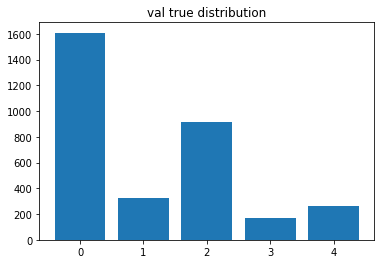

In [5]:
# Divide train & val data
train_labels = pd.read_csv(train_label_file)
classes = train_labels['diagnosis'].unique()
classes = np.sort(classes)

global N, C, L
N = train_labels.shape[0]
C = classes.size
L = 224

train_class, val_class, class_weight = divide_data(train_dir_processed, val_dir_processed, train_labels, N, classes)
print(class_weight)

**2.5 Optional re-divide**

Class 0: N_train = 1618, N_val = 187
Class 1: N_train = 333, N_val = 37
Class 2: N_train = 901, N_val = 98
Class 3: N_train = 175, N_val = 18
Class 4: N_train = 267, N_val = 28
{0: 1.0, 1: 2.204281937243705, 2: 1.340068081826057, 3: 3.0406766164316594, 4: 2.461691510655419}


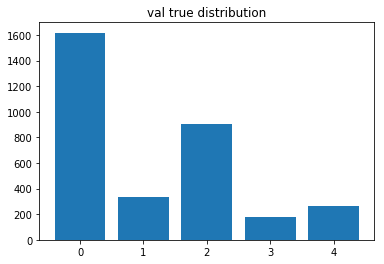

In [6]:
combine_data(train_dir_processed, val_dir_processed, classes)
train_class, val_class, class_weight = divide_data(train_dir_processed, val_dir_processed, train_labels, N, classes)
print(class_weight)

**3. Build model**

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

"""
Single conv layer in CNN model
"""
def conv_layer(x_in, filters, kernel_dim, drop_rate=0.0, batch_norm=True, max_pool=True):
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(kernel_dim,kernel_dim), strides=(1,1), padding='same',
               kernel_initializer='he_normal')(x_in)
    x = tf.keras.layers.Activation('relu')(x)
    if drop_rate > 0.0:
        x = tf.keras.layers.Dropout(drop_rate)(x)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    if max_pool:
        x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    return x
    

"""
Single dense/FC layer in CNN model
"""
def dense_layer(x_in, units, activation='tanh', drop_rate=0.0):
    x = tf.keras.layers.Dense(units, activation=activation)(x_in)
    if drop_rate > 0.0:
        x = tf.keras.layers.Dropout(rate = drop_rate)(x)
    return x

"""
Custom loss function
"""
def custom_loss(y_true, y_pred):
    class_true = K.cast(K.expand_dims(K.argmax(y_true, axis=-1), axis=-1), 'float32')   # y_true is one-hot
    i = np.array([[0, 1, 2, 3, 4]]).astype('float32')
    alpha = 30 * K.square(i - class_true) / K.sum(K.square(i - class_true), axis=0)
    # cross entropy
    loss1 = -K.sum(y_true * K.log(y_pred), axis=-1)
    # additional term to penalize worse predictions
    loss2 = -K.sum(alpha * (1-y_true) * K.log(1-y_pred), axis=-1)
    
    return loss1 + loss2


"""
Custom eval metric: quadratic weighted kappa
"""
def qwk(y_true, y_pred):
    # compute confution matrix
    y_true_label = K.argmax(y_true, axis=-1)    # one-hot to class number
    y_pred_label = K.argmax(y_pred, axis=-1)
    confusion = tf.math.confusion_matrix(y_true_label, y_pred_label, num_classes=5, dtype='float32')
    
    # compute quadratic weight
    alpha = np.square([[i-j for i in range(5)] for j in range(5)]).astype('float32')

    # compute observed and expected matrix
    observed = confusion/tf.reduce_sum(confusion)  # count -> distribution
    P_pred = tf.reduce_sum(confusion, axis=0)/tf.reduce_sum(confusion)
    P_true = tf.reduce_sum(confusion, axis=1)/tf.reduce_sum(confusion)
    expected = tf.tensordot(P_true, P_pred, axes=0)
    
    # compute kappa
    kappa = 1 - tf.reduce_sum(tf.multiply(alpha, observed))/tf.reduce_sum(tf.multiply(alpha, expected))
    return kappa


"""
Use transfer learning
"""
def transfer_model():
    base_model = tf.keras.applications.VGG16(input_shape=(L,L,3),
                                             weights='../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                             include_top=False)
    
    #base_model = tf.keras.applications.ResNet50(input_shape=(L,L,3),
    #                                            weights='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    #                                            include_top=False)

    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    
    # dense layers
#    x = tf.keras.layers.Flatten()(x)
#    x = tf.keras.layers.GlobalAveragePooling2D()(x)    # faster processing, omit spacial, vessel leakage can happen anywhere
    x = tf.keras.layers.GlobalMaxPooling2D()(x)         # you only need to find certain features once, other areas can be blank
#    x = dense_layer(x, units=512, activation='elu', drop_rate=0.25)
    x = dense_layer(x, units=128, activation='tanh', drop_rate=0.4)
    
    # class pred
    x_out = tf.keras.layers.Dense(5, activation='softmax')(x)
    
    # compile model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=x_out)
#    sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
    adam = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    
    model.compile(optimizer=adam, loss=custom_loss, metrics=['acc', qwk])
    
    return model

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

**4. Train model**

In [8]:
"""
Generate (and augment) data for model
"""
def gen_data(train_dir, val_dir, batch_size):
    print("Train set:")
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       #rotation_range=360,  # an eyeball at any angle is still the same
                                       horizontal_flip=True,        # left/right eye symmetry
                                       vertical_flip=True,          # left/right eye symmetry
                                       samplewise_center=True,     # centering
                                       samplewise_std_normalization=True) # standardizing
                                       #brightness_range=(0.5, 1))   # there are dark imgs
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        target_size=(L, L))
    print("Val set:")
    val_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     samplewise_center=True,
                                     samplewise_std_normalization=True)
    val_generator = val_datagen.flow_from_directory(val_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(L, L))
    
    return train_generator, val_generator

"""
Display training history
"""
def show_history(history):
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    qwk=history.history['qwk']
    val_qwk=history.history['val_qwk']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    epochs = list(range(1, len(acc)+1))
    plt.figure(1)
    plt.plot(epochs, loss, 'b', epochs, val_loss, 'r')
    plt.title('loss')
    plt.legend(('train', 'val'))
    
    plt.figure(2)
    plt.plot(epochs, acc, 'b', epochs, val_acc, 'r')
    plt.title('accuracy')
    plt.legend(('train', 'val'))
    
    plt.figure(3)
    plt.plot(epochs, qwk, 'b', epochs, val_qwk, 'r')
    plt.title('weighted kappa')
    plt.legend(('train', 'val'))

    plt.figure(4)
    plt.plot(loss, qwk)
    plt.title('train: qwk vs loss')
    
    plt.figure(5)
    plt.plot(val_loss, val_qwk)
    plt.title('val: qwk vs loss')

Train set:
Found 3294 images belonging to 5 classes.
Val set:
Found 368 images belonging to 5 classes.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________

Text(0.5, 1.0, 'val pred distribution')

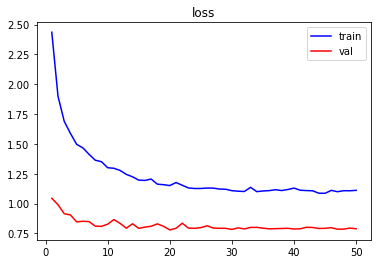

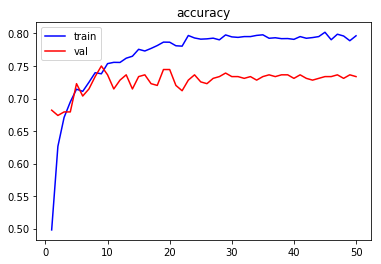

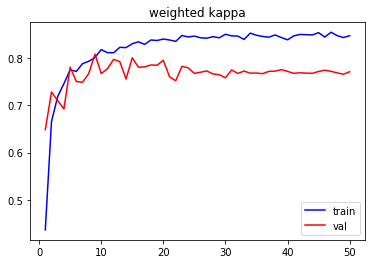

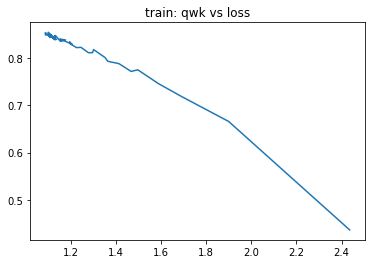

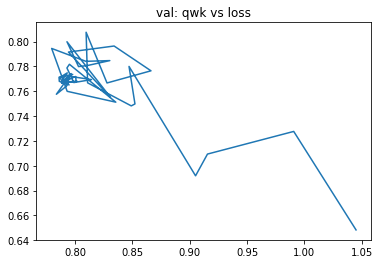

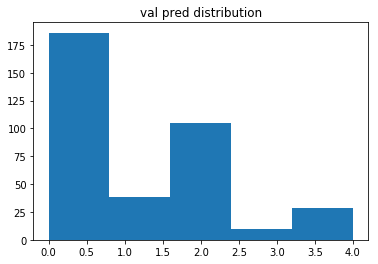

In [9]:
train_gen, val_gen = gen_data(train_dir_processed, val_dir_processed, batch_size=128)

model = transfer_model()
model.summary()
callbacks = [#tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  min_delta=0.0004,
                                                  patience=3, factor=0.5, min_lr=1e-5,  mode='auto', verbose=1)]
#             tf.keras.callbacks.ModelCheckpoint(filepath = 'weights-best.hdf5', 
#                                                monitor='val_loss', save_best_only=True)]

os.system('echo ' + 'training')
history = model.fit_generator(train_gen,
                              validation_data = val_gen,
                              steps_per_epoch=math.ceil(train_gen.samples*2/train_gen.batch_size),
                              class_weight=class_weight,
                              epochs = 50,    # takes 8:47 to run 65 epochs. any more the kernel will fail
                              validation_steps=math.ceil(val_gen.samples/val_gen.batch_size),
                              callbacks = callbacks,
                              use_multiprocessing=False,
                              verbose = 1)

show_history(history)

val_pred = model.predict_generator(val_gen, workers=1)    # workers!=1 will mess up the order
val_pred_class = np.argmax(val_pred, axis=1)
plt.figure(6)
plt.hist(val_pred_class, bins=5)
plt.title('val pred distribution')

**5. Generate test set results**

In [10]:
output_filename = 'submission.csv'

# copied from a kernel
sam_sub_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sam_sub_df["id_code"]=sam_sub_df["id_code"].apply(lambda x:x+".png")

test_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True)
test_gen = test_datagen.flow_from_dataframe(  
        dataframe=sam_sub_df,
        directory = test_dir_processed,    
        x_col="id_code",
        target_size = (L, L),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

test_gen.reset()
predict = model.predict_generator(test_gen,
                                  steps = len(test_gen.filenames),
                                  use_multiprocessing=False)

filenames = test_gen.filenames
results = pd.DataFrame({"id_code":filenames,
                        "diagnosis":np.argmax(predict,axis=1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv(output_filename, index=False)

Found 1928 validated image filenames.


Text(0.5, 1.0, 'test pred distribution')

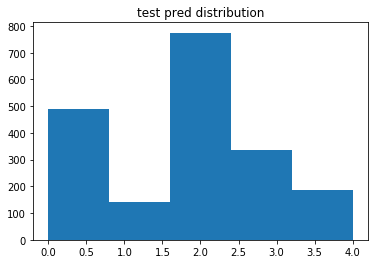

In [11]:
test_pred_class = pd.read_csv(output_filename)
plt.hist(test_pred_class['diagnosis'], bins=5)
plt.title('test pred distribution')